### 【問題1】仮定関数
### 【問題2】最急降下法
### 【問題3】推定
### 【問題4】目的関数
### 【問題5】学習と推定
### 【問題6】学習曲線のプロット
### 【問題7】決定領域の可視化

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style='whitegrid')
import warnings
warnings.simplefilter('ignore')

# 分類境界のプロットクラスを定義
from matplotlib.colors import ListedColormap

class DecisionPlotter:
    def __init__(self, X, y, classifier, test_idx=None):
        self.X = X
        self.y = y
        self.classifier = classifier
        self.test_idx = test_idx
        self.colors = ['#de3838', '#007bc3', '#ffd12a']
        self.markers = ['o', 'x', ',']
        self.labels = ['setosa', 'versicolor', 'virginica']

    def plot(self):
        cmap = ListedColormap(self.colors[:len(np.unique(self.y))])
        # グリットポイントの生成
        xx1, xx2 = np.meshgrid(
            np.arange(self.X[:, 0].min() - 1, self.X[:, 0].max() + 1, 0.01),
            np.arange(self.X[:, 1].min() - 1, self.X[:, 1].max() + 1, 0.01))
        # 各meshgridの予測値を求める
        Z = self.classifier.predict(np.array([xx1.ravel(), xx2.ravel()]).T)
        Z = Z.reshape(xx1.shape)
        # 等高線のプロット
        plt.contourf(xx1, xx2, Z, alpha=0.2, cmap=cmap)
        plt.xlim(xx1.min(), xx1.max())
        plt.ylim(xx2.min(), xx2.max())
        # classごとにデータ点をプロット
        for idx, cl, in enumerate(np.unique(self.y)):
            plt.scatter(
                x=self.X[self.y == cl, 0], y=self.X[self.y == cl, 1],
                alpha=0.8,
                c=self.colors[idx],
                marker=self.markers[idx],
                label=self.labels[idx])
        # テストデータの強調
        if self.test_idx is not None:
            X_test, y_test = self.X[self.test_idx, :], self.y[self.test_idx]
            plt.scatter(
                X_test[:, 0], X_test[:, 1],
                alpha=0.9,
                c='None',
                edgecolor='gray',
                marker='o',
                s=100,
                label='test set')
        plt.legend()

from sklearn.datasets import load_iris

iris = load_iris()  # irisデータセットの読み込み
df_iris = pd.DataFrame(iris.data, columns=iris.feature_names)
df_iris['class'] = iris.target
df_iris

df_iris = df_iris[df_iris['class'] != 2]  # class = 0, 1のデータのみを取得
df_iris = df_iris[['petal length (cm)', 'petal width (cm)', 'class']]
X = df_iris.iloc[:, :-1].values
y = df_iris.iloc[:, -1].values

print(f'X.shape: {X.shape}')
print(f'y.shape: {y.shape}')


from sklearn.preprocessing import StandardScaler

# 標準化のインスタンスを生成（平均=0, 標準偏差=1 に標準化）
sc = StandardScaler()
X_std = sc.fit_transform(X)


from sklearn.model_selection import train_test_split

# train data 80%, test data 20%の割合で分割
X_train, X_test, y_train, y_test = train_test_split(X_std, y, test_size=0.2, random_state=1, stratify=y)

print(f'X_train.shape: {X_train.shape}')
print(f'X_test.shape: {X_test.shape}')
print(f'y_train.shape: {y_train.shape}')
print(f'y_test.shape: {y_test.shape}')


class MyLogisticRegression:
    """ロジスティック回帰実行クラス

    Attributes
    -------------
    eta : float
        学習率
    epoch : int
        エポック数
    random_state : int
        乱数シード
    is_trained : bool
        学習完了フラグ
    num_samples : int
        学習データのサンプル数
    num_features : int
        特徴量の数
    w : NDArray[float]
        パラメータベクトル: (num_features, )のndarray
    costs : NDArray[float]
        各エポックでの損失関数の値の履歴: (epoch, )のndarray

    Methods
    -----------
    fit -> None
        学習データについてパラメータベクトルを適合させる
    predict -> NDArray[int]
        予測値を返却する
    """
    def __init__(self, eta=0.01, n_iter=50, random_state=42):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        self.is_trained = False

    def fit(self, X, y):
        """
        学習データについてパラメータベクトルを適合させる

        Parameters
        --------------
        X : NDArray[NDArray[float]]
            学習データ: (num_samples, num_features)の行列
        y : NDArray[int]
            学習データの教師ラベル: (num_features, )のndarray
        """
        self.num_samples = X.shape[0]  # サンプル数
        self.num_features = X.shape[1]  # 特徴量の数
        # 乱数生成器
        rgen = np.random.RandomState(self.random_state)
        # 正規乱数を用いてパラメータベクトルを初期化
        self.w = rgen.normal(loc=0.0, scale=0.01, size=1+self.num_features)
        self.costs = []  # 各エポックでの損失関数の値を格納する配列
        # パラメータベクトルの更新
        for _ in range(self.n_iter):
            net_input = self._net_input(X)
            output = self._activation(net_input)
            # 式(2)
            self.w[1:] += self.eta * X.T @ (y - output)
            self.w[0] += self.eta * (y - output).sum()
            # 損失関数: 式(1)
            cost = (-y @ np.log(output)) - ((1-y) @ np.log(1-output))
            self.costs.append(cost)
        # 学習完了のフラグを立てる
        self.is_trained = True

    def predict(self, X):
        """
        予測値を返却する

        Parameters
        --------------
        X : NDArray[NDArray[float]]
            予測するデータ: (any, num_features)の行列

        Returens
        -----------
        NDArray[int]
            0 or 1 (any, )のndarray
        """
        if not self.is_trained:
            raise Exception('This model is not trained.')
        return np.where(self._activation(self._net_input(X)) >= 0.5, 1, 0)

    def _net_input(self, X):
        """
        データとパラメータベクトルの内積を計算する

        Parameters
        --------------
        X : NDArray[NDArray[float]]
            データ: (any, num_features)の行列

        Returns
        ----------
        NDArray[float]
            データとパラメータベクトルの内積の値:　(any, )のndarray
        """
        return X @ self.w[1:] + self.w[0]

    def _activation(self, z):
        """
        活性化関数（シグモイド関数）

        Parameters
        --------------
        z : NDArray[float]
            (any, )のndarray

        Returns
        ----------
        NDArray[float]
            各成分に活性化関数を適応した (any, )のndarray
        """
        return 1 / (1 + np.exp(-np.clip(z, -250, 250)))

X.shape: (100, 2)
y.shape: (100,)
X_train.shape: (80, 2)
X_test.shape: (20, 2)
y_train.shape: (80,)
y_test.shape: (20,)


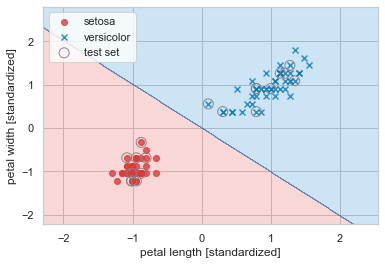

In [2]:
# ロジスティック回帰モデルの学習
lr = MyLogisticRegression(eta=0.5, n_iter=1000, random_state=42)
lr.fit(X_train, y_train)

# 訓練データとテストデータを結合
X_comb = np.vstack((X_train, X_test))
y_comb = np.hstack((y_train, y_test))
# プロット
dp = DecisionPlotter(X=X_comb, y=y_comb, classifier=lr, test_idx=range(len(y_train), len(y_comb)))
dp.plot()
plt.xlabel('petal length [standardized]')
plt.ylabel('petal width [standardized]')
plt.show()

2
2


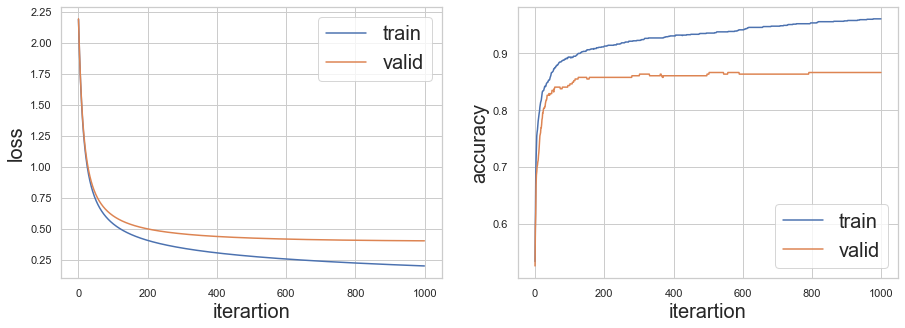

0.9085714285714286


In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split
import pandas as pd

def init_parameter(n_classes, n_futures):
    w = np.ones((n_futures, n_classes))
    b = np.ones((1, n_classes))
    return w, b


def linear_trans(x, w, b):
    return np.dot(x, w) + b


def softmax(z):
    return np.exp(z) / np.sum(np.exp(z), axis=1)[:, np.newaxis]


def get_loss(y_true, y_pred):
    return -np.sum(y_true * np.log(y_pred)) / y_true.shape[0]


def get_optimized_parameter(x, y_true, y_pred, w, b, alpha):
    w -= alpha * np.dot(x.T, y_pred - y_true) / x.shape[0]
    b -= alpha * np.dot(np.ones((1, x.shape[0])), y_pred - y_true) / x.shape[0]
    return w, b


def get_predict(y_pred_proba):
    y_arg_max = y_pred_proba.argmax(axis=1)
    y_pred = np.zeros(y_pred_proba.shape)
    for i in range(y_pred_proba.shape[0]):
        y_pred[i, y_arg_max[i]] = 1
    return y_pred


def get_accuracy(y, y_pred_proba):
    y_pred = get_predict(y_pred_proba)
    count = 0
    for i in range(len(y)):
        if (y[i] == y_pred[i]).all():
            count += 1
    return count / len(y)


def plot_iteration(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list):
    fig = plt.figure(figsize=(15, 5))
    ax1 = fig.add_subplot(1, 2, 1)
    ax1.set_xlabel("iterartion", fontsize=20)
    ax1.set_ylabel("loss", fontsize=20)
    ax1.plot(train_loss_list, label="train")
    ax1.plot(valid_loss_list, label="valid")
    ax1.legend(fontsize=20)

    ax2 = fig.add_subplot(1, 2, 2)
    ax2.set_xlabel("iterartion", fontsize=20)
    ax2.set_ylabel("accuracy", fontsize=20)
    ax2.plot(train_acc_list, label="train")
    ax2.plot(valid_acc_list, label="valid")
    ax2.legend(fontsize=20)
#     plt.savefig("./loss-acc-iteration.png")
    plt.show()


def optimize(x_train, y_train, x_valid, y_valid, alpha, iter_max):
    # 教師データのロス
    train_loss_list = []
    # 教師データの精度
    train_acc_list = []
    # テストデータのロス
    valid_loss_list = []
    # テストデータの精度
    valid_acc_list = []

    # W,bの初期化
    print(len(x_train.shape))
    print(len(y_train.shape))
    w, b = init_parameter(y_train.shape[1], x_train.shape[1])
    # 予測結果の初期値
    y_train_pred = softmax(linear_trans(x_train, w, b))

    for count in range(iter_max):
        # 教師データで最適化
        w, b = get_optimized_parameter(x_train, y_train, y_train_pred, w, b, alpha)

        # 教師データと検証データを最適化したW,bで予測
        y_train_pred = softmax(linear_trans(x_train, w, b))
        y_valid_pred = softmax(linear_trans(x_valid, w, b))

        # 教師データと検証データのロスを保存
        train_loss_list.append(get_loss(y_train, y_train_pred))
        valid_loss_list.append(get_loss(y_valid, y_valid_pred))

        # 教師データと検証データの精度を保存
        train_acc_list.append(get_accuracy(y_train, y_train_pred))
        valid_acc_list.append(get_accuracy(y_valid, y_valid_pred))

    plot_iteration(train_loss_list, train_acc_list, valid_loss_list, valid_acc_list)

    return w, b


def get_split_data(x, y, size_ratio):
    # データ数
    n_samples = x.shape[0]
    # 分類クラス数
    n_classes = len(set(list(y)))

    # 教師データ最大index
    n_train_max = round(n_samples * size_ratio[0])
    # 検証データ最大index
    n_valid_max = n_train_max + round(n_samples * size_ratio[1])
    # テストデータ最大index
    n_test_max = n_valid_max + round(n_samples * size_ratio[2])

    # シャッフル
    np.random.seed(0)
    p = np.random.permutation(n_samples)
    x_shuffle = x[p, :]
    y_shuffle = y[p]

    # 教師データ
    x_train = x_shuffle[0:n_train_max, :]
    y_train = np.identity(n_classes)[y_shuffle[0:n_train_max]]

    # 検証データ
    x_valid = x_shuffle[n_train_max:n_valid_max, :]
    y_valid = np.identity(n_classes)[y_shuffle[n_train_max:n_valid_max]]

    # テストデータ
    x_test = x_shuffle[n_valid_max:n_test_max, :]
    y_test = np.identity(n_classes)[y_shuffle[n_valid_max:n_test_max]]

    return x_train, y_train, x_valid, y_valid, x_test, y_test


# データ準備
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1, )
# MNISTデータの一部を取得
x_train, y_train, x_valid, y_valid, x_test, y_test = get_split_data(
    mnist.data / 255, mnist.target.astype(int), (0.02, 0.005, 0.005))

# 学習/推測
alpha = 0.1
iter_max = 1000
w, b = optimize(x_train, y_train, x_valid, y_valid, alpha, iter_max)
y_predict_proba = softmax(linear_trans(x_test, w, b))
print(get_accuracy(y_test, y_predict_proba))